In [126]:
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import sys
import os 
import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
#import memory_profiler
from packaging.version import parse as parse_version
from memory_profiler import profile

# Load the memory_profiler extension
#get_ipython().run_line_magic('load_ext', 'memory_profiler')

from pathlib import Path


import sparseRRR


AttributeError: Module 'scipy' has no attribute 'empty'

In [69]:
import black
import jupyter_black

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

jupyter_black.load(line_length=79)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-25 19:16:48CEST

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

sklearn: 1.5.1

pandas       : 2.2.2
jupyter_black: 0.3.4
black        : 24.4.2
numpy        : 2.0.1
scipy        : 1.14.0
matplotlib   : 3.9.1
sklearn      : 1.5.1

Watermark: 2.4.3



In [70]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [71]:
plt.style.use("../matplotlib_style.txt")

In [72]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [73]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [c if c[-1] != "+" and c[-1] != "-" else c[:-1] for c in meta["Cre"].values]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [np.unique(meta["Date"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [np.unique(meta["Mouse age"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [np.unique(meta["Mouse"].values[sliceids == s]).size == 1 for s in sliceids]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [74]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [75]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [77]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [78]:
cluster_colors.shape

(1329,)

In [79]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [114]:
rna_type.shape
print(rna_type)

['L5 ET_1' 'L5 IT_2' 'L5 IT_1' ... 'L5 ET_1' nan 'Pvalb Gpr149']


In [81]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [82]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [83]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [names2ephys[c] if c in names2ephys else ephysData[0] * np.nan for c in cells]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [84]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [ ]:
ephysData_filtered

In [85]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

In [86]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats

In [87]:
PCinit = PCA(n_components=2).fit_transform(ephysData_filtered)
PCinit = PCinit / np.std(PCinit[:, 0]) * 0.0001

In [88]:
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(
    ephysData_filtered
)

In [108]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """
    n_clusters = len(m)  # number of clusters
    n_dims = x.shape[1]  # number of dimensions
    n_samples = x.shape[0]  # number of samples

    # LL = data_likelihood  # log likelihood of the data given the model

    # Calculate the log likelihood of the data given the model
    expectation = np.zeros((n_samples, n_clusters), dtype=np.float64)

    for i, k in enumerate(range(n_clusters)):
        pi_k = p[k]
        mu_k = m[k]
        cov_k = S[k] + 1e-6 * np.eye(n_dims)
        expectation[:, k] = pi_k * stats.multivariate_normal(mean=mu_k, cov=cov_k).pdf(
            x
        )
        totals = np.sum(expectation, 1) 
        LL = np.sum(np.log(totals))

    # number of parameters:

    P = (n_clusters - 1) + n_clusters * n_dims + n_clusters * n_dims * (n_dims + 1) / 2

    bic = -2 * LL + P * np.log(n_samples)
    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    return bic, LL

In [109]:
possible_clusters = range(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(possible_clusters)))
LL = np.zeros((num_seeds, len(possible_clusters)))
sklearn_BIC = np.zeros((num_seeds, len(possible_clusters)))
sklearn_LL = np.zeros((num_seeds, len(possible_clusters)))

for i, n_clusters in enumerate(possible_clusters):
    for j in range(num_seeds):
        gmm = GMM(n_components=n_clusters, random_state=j).fit(ephysData_filtered)
        cluster_ids = gmm.predict(ephysData_filtered)
        likelihood = gmm.score_samples(ephysData_filtered)  # log likelihood
        means = gmm.means_
        covariances = gmm.covariances_
        weights = gmm.weights_
        BIC[j, i], LL[j, i] = mog_bic(ephysData_filtered, means, covariances, weights)
        sklearn_BIC[j, i] = gmm.bic(ephysData_filtered)
        sklearn_LL[j, i] = gmm.score(ephysData_filtered)

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_13978/2553348460.py:47: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(totals))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_13978/2553348460.py:47: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(totals))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_13978/2553348460.py:47: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(totals))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_13978/2553348460.py:47: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(totals))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_13978/2553348460.py:47: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(totals))
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_13978/2553348460.py:47: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(totals))
/var/folders/g_/dvk6nf

In [110]:
# Get the optimal number of clusters for the sklearn GMM
sklearn_model_index, sklearn_cluster_index = np.where(sklearn_BIC == sklearn_BIC.min())
sklearn_optimal_cluster_number = possible_clusters[sklearn_cluster_index[0]]
sklearn_lowest_bic = sklearn_BIC[sklearn_model_index[0], :]
print(f"Optimal number of clusters: {sklearn_optimal_cluster_number}")

Optimal number of clusters: 4


<ErrorbarContainer object of 3 artists>

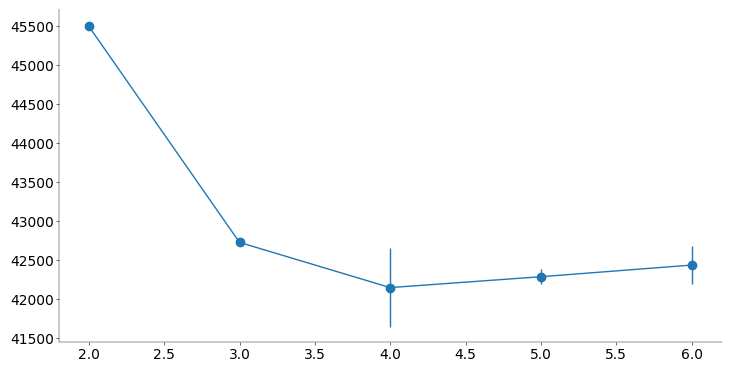

In [111]:
plt.errorbar(
    possible_clusters,
    BIC.mean(axis=0),
    yerr=BIC.std(axis=0),
    label="Custom BIC",
    fmt="o-",
)


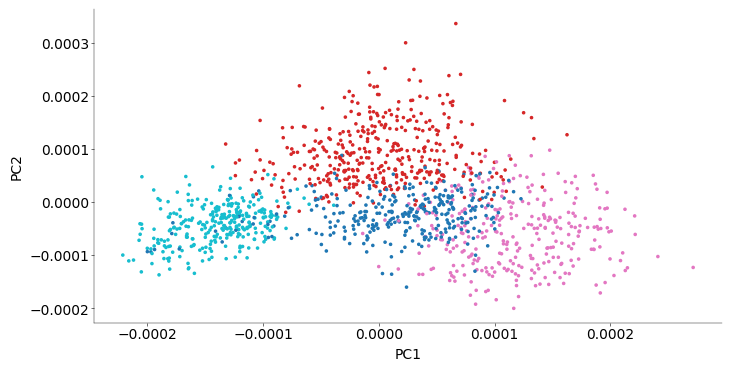

In [112]:
colors = ["red", "blue", "green", "purple", "orange", "black"]
gmm = GMM(n_components=sklearn_optimal_cluster_number, random_state=42).fit(
    ephysData_filtered
)
cluster_ids = gmm.predict(ephysData_filtered)
likelihood = gmm.score_samples(ephysData_filtered)  # log likelihood
means = gmm.means_
covariances = gmm.covariances_

plt.scatter(PCinit[:, 0], PCinit[:, 1], s=10, c=cluster_ids, cmap="tab10", alpha=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Text(0, 0.5, '')

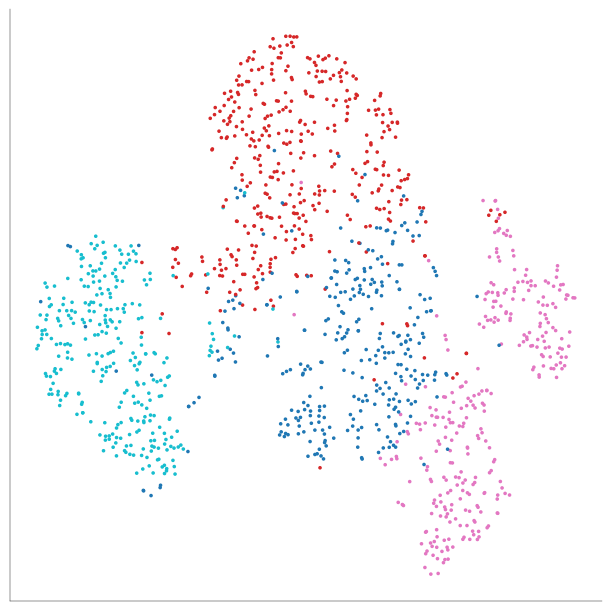

In [113]:
Z = TSNE(
    init=PCinit, early_exaggeration=4, random_state=42, perplexity=20
).fit_transform(ephysData_filtered)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(Z[:, 0], Z[:, 1], c=cluster_ids, cmap="tab10", s=10)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    